### **Importing Libraries**

In [22]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

from torchvision.utils import save_image
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable
import numpy as np
from collections import OrderedDict
import itertools
import os
import glob
import random

%matplotlib inline

### **Data Loader**

In [23]:
dir_root = './data/flags-dataset/'

In [24]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.files_A = sorted(glob.glob(os.path.join(root, '%s/A' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%s/B' % mode) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
            
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))
            

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [25]:
# Dataset loader
batch_size=1
transforms_ = [transforms.RandomHorizontalFlip(),
               transforms.Grayscale(num_output_channels=3),
               transforms.Resize((256, 256)),
               transforms.ToTensor()]
dataset = ImageDataset(root=dir_root, transforms_=transforms_, unaligned=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [26]:
dataset[0]["A"].shape

torch.Size([3, 256, 256])

### **Sample Image**

torch.Size([256, 256])


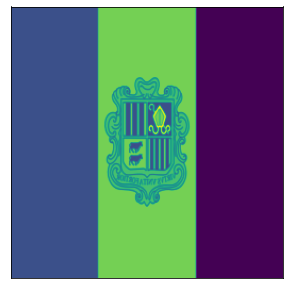

In [27]:
fig = plt.figure(figsize=(5,5))
sample = dataset[0]["A"]
print(sample[0].shape)
plt.xticks([])
plt.yticks([])
plt.imshow(sample[0])
plt.show()

### **Weight Initialization**

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
ngpu = 1
ndc = 128
ngc = 128
nc = 3
lr =0.0002
device = ('cuda' if torch.cuda.is_available else 'cpu')

In [10]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        print(x.shape)
        return x

### **Resnet Block**

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

### **Generator**

In [12]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, rblock=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(rblock):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [13]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [14]:
# Networks
G_AB = Generator(3, 3).to(device)
G_BA = Generator(3, 3).to(device)
d_A = Discriminator(3).to(device)
d_B = Discriminator(3).to(device)

In [15]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [16]:
n_epochs = 25

G_AB.apply(weights_init)
G_BA.apply(weights_init)
d_A.apply(weights_init)
d_B.apply(weights_init)

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizerG = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizerD_A = torch.optim.Adam(d_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerD_B = torch.optim.Adam(d_B.parameters(), lr=lr, betas=(0.5, 0.999))

lr_schedulerG = torch.optim.lr_scheduler.LambdaLR(optimizerG, lr_lambda=LambdaLR(n_epochs, 0, 5).step)
lr_schedulerD_A = torch.optim.lr_scheduler.LambdaLR(optimizerD_A, lr_lambda=LambdaLR(n_epochs, 0, 5).step)
lr_schedulerD_B = torch.optim.lr_scheduler.LambdaLR(optimizerD_B, lr_lambda=LambdaLR(n_epochs, 0, 5).step)

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if 'cuda' else torch.Tensor
input_A = Tensor(batch_size, 3, 256, 256)
input_B = Tensor(batch_size, 3, 256, 256)
target_real = Variable(Tensor(batch_size).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batch_size).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [17]:
# Lists to keep track of progress

G_losses = []
DA_losses = []
DB_losses = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(n_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        optimizerG.zero_grad()
        
        img_A = data['A'].to(device)
        #print(f'img A {i} {img_A.shape}')
        img_B = data['B'].to(device)
        #print(f'img B {i} {img_B.shape}')
        
        # Identity Loss
        same_B = G_AB(img_B)
        loss_identity_B = criterion_identity(same_B, img_B) * 5.0
        
        same_A = G_BA(img_A)
        loss_identity_A = criterion_identity(same_A, img_A) * 5.0
        
        #GAN Loss
        fake_B = G_AB(img_A)
        pred_fake = d_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)
        
        fake_A = G_BA(img_B)
        pred_fake = d_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)
        
        # Cycle loss
        recovered_A = G_BA(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, img_A)*10.0

        recovered_B = G_AB(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, img_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizerG.step()
        ###################################

        ###### Discriminator A ######
        optimizerD_A.zero_grad()

        # Real loss
        pred_real = d_A(img_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = d_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizerD_A.step()
        ###################################

        ###### Discriminator B ######
        optimizerD_B.zero_grad()

        # Real loss
        pred_real = d_B(img_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = d_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizerD_B.step()
        ###################################
        
        G_losses.append(round(loss_G.item(),3))
        DA_losses.append(round(loss_D_A.item(),3))
        DB_losses.append(round(loss_D_B.item(),3))
        
    if epoch % 3 == 0:
        print(f'loss_G: {loss_G}, loss_G_identity: {loss_identity_A + loss_identity_B}, loss_G_GAN: {loss_GAN_A2B + loss_GAN_B2A},loss_G_cycle: {loss_cycle_ABA + loss_cycle_BAB}, loss_D: {loss_D_A + loss_D_B}')
        save_image(img_A, 'real_A'+str(epoch)+'.png')
        save_image(img_B, 'real_B'+str(epoch)+'.png')
        save_image(fake_A, 'fake_A'+str(epoch)+'.png')
        save_image(fake_B, 'fake_B'+str(epoch)+'.png')
    
    # Update learning rates
    lr_schedulerG.step()
    lr_schedulerD_A.step()
    lr_schedulerD_B.step()

    # Save models checkpoints
    torch.save(G_AB.state_dict(), 'output/G_AB.pth')
    torch.save(G_BA.state_dict(), 'output/G_BA.pth')
    torch.save(d_A.state_dict(), 'output/d_A.pth')
    torch.save(d_B.state_dict(), 'output/d_B.pth')

Starting Training Loop...


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency e

loss_G: 5.837184906005859, loss_G_identity: 1.67202889919281, loss_G_GAN: 0.8924916982650757,loss_G_cycle: 3.2726640701293945, loss_D: 0.44784289598464966


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images

loss_G: 4.999104976654053, loss_G_identity: 1.0485997200012207, loss_G_GAN: 1.451328158378601,loss_G_cycle: 2.4991769790649414, loss_D: 0.34401175379753113


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images

loss_G: 5.310812950134277, loss_G_identity: 1.5379325151443481, loss_G_GAN: 2.1220076084136963,loss_G_cycle: 1.6508724689483643, loss_D: 0.20617038011550903


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images

loss_G: 4.332240581512451, loss_G_identity: 1.1509205102920532, loss_G_GAN: 1.4937589168548584,loss_G_cycle: 1.68756103515625, loss_D: 0.15592478215694427


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images

loss_G: 4.124005317687988, loss_G_identity: 0.7077036499977112, loss_G_GAN: 1.814223051071167,loss_G_cycle: 1.6020784378051758, loss_D: 0.07107896357774734


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images

loss_G: 3.5299644470214844, loss_G_identity: 0.6567195653915405, loss_G_GAN: 1.6436488628387451,loss_G_cycle: 1.2295957803726196, loss_D: 0.0503292940557003


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images

loss_G: 2.509216547012329, loss_G_identity: 0.100858673453331, loss_G_GAN: 2.0502769947052,loss_G_cycle: 0.3580809235572815, loss_D: 0.35272911190986633


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images

loss_G: 2.7339651584625244, loss_G_identity: 0.23567484319210052, loss_G_GAN: 1.9062690734863281,loss_G_cycle: 0.5920213460922241, loss_D: 0.01845651865005493


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images

loss_G: 2.2867562770843506, loss_G_identity: 0.1975589245557785, loss_G_GAN: 1.486809492111206,loss_G_cycle: 0.6023877859115601, loss_D: 0.05987806245684624


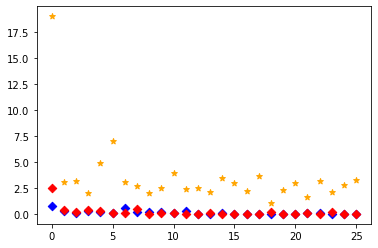

In [18]:
for epoch, i in enumerate(range(0, len(G_losses),1327)):
    plt.scatter(epoch,G_losses[i],c='orange', marker="*")
    plt.scatter(epoch,DA_losses[i],c='blue', marker='D')
    plt.scatter(epoch,DB_losses[i],c='red',marker='D')

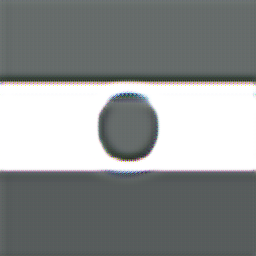

In [14]:
transform_to_PIL = transforms.ToPILImage()
trans1 = transforms.ToTensor()
transform_to_PIL(trans1(Image.open('fake_A0.png'))).convert("RGB")

In [52]:
transform_to_PIL(Image.open('fake_A12.png').numpy())

AttributeError: 'PngImageFile' object has no attribute 'numpy'